In [1]:
import numpy as np
import json
from intvalpy import Interval, Tol, precision
import matplotlib.pyplot as plt
from intvalpy_fix import IntLinIncR2

In [2]:
X = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
eps = 1 / 16384

In [3]:
def load_data(directory, side):
    loaded_data = np.zeros((8, 1024, 1100, 2), dtype=object)

    for offset, value_x in enumerate(X):
        filepath = f"{directory}/{value_x}lvl_side_{side}_fast_data.json"
        with open(filepath, "rt") as f:
            data = json.load(f)

        for i in range(8):
            for j in range(1024):
                sensor_data = data["sensors"][i][j]
                start_idx = offset * 100
                end_idx = start_idx + len(sensor_data)
                loaded_data[i, j, start_idx:end_idx, 0] = value_x
                loaded_data[i, j, start_idx:end_idx, 1] = sensor_data

    return loaded_data

In [4]:
data = load_data("data/04_10_2024_070_068", "a")

In [5]:
def amount_of_neg(all_data, coord_1, coord_2):
    # Извлечение данных x и y
    x, y = zip(*all_data[coord_1][coord_2])
    y = np.array(y)

    # Инициализация массивов для вычислений
    num_x_values = len(X)
    y_ex_up = np.full(num_x_values, -np.inf)
    y_ex_down = np.full(num_x_values, np.inf)
    y_in_up = np.full(num_x_values, -np.inf)
    y_in_down = np.full(num_x_values, np.inf)

    # Четвертины для выборок
    q_1 = 100 // 4
    q_3 = 100 * 3 // 4 - 1

    for i in range(num_x_values):
        # Извлечение y для текущего значения x
        y_list = np.sort(y[i * 100:(i + 1) * 100])

        # Вычисление границ
        iqr = y_list[q_3] - y_list[q_1]
        y_in_down[i] = y_list[q_1] - eps
        y_in_up[i] = y_list[q_3] + eps
        y_ex_up[i] = min(y_list[q_3] + 1.5 * iqr, y_list[-1])
        y_ex_down[i] = max(y_list[q_1] - 1.5 * iqr, y_list[0])

    # Формирование матриц X и Y
    X_mat = np.array([[[x_val, x_val], [1, 1]] for x_val in X])
    Y_vec = np.array([[y_in_down[i], y_in_up[i]] for i in range(num_x_values)])

    # Интервальные расчёты
    X_mat_interval = Interval(X_mat)
    Y_vec_interval = Interval(Y_vec)
    to_remove = []

    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat_interval, Y_vec_interval)

    for i in range(num_x_values):
        X_mat_small = Interval([X_mat[i]])
        Y_vec_small = Interval([Y_vec[i]])
        value = Tol.value(X_mat_small, Y_vec_small, b_vec)
        if value < 0:
            to_remove.append(i)

    return len(to_remove)


In [6]:
f_values = {0: None, 5: None, 9: None}

def find_first_match(data, i_range, j_range):
    global f_values
    for i in i_range:
        for j in j_range:
            # Выход, если все значения найдены
            if all(f_values.values()):
                return

            n = amount_of_neg(data, i, j)
            # print((i, j), n)

            # Проверяем, нужно ли обновить словарь
            if n in f_values and f_values[n] is None:
                f_values[n] = (i, j)
                print((i, j), n)

# Запуск с оптимальными диапазонами
find_first_match(data, range(8), range(1024))


(0, 7) 0
(0, 19) 5
(0, 612) 9


In [7]:
def regression_type_tol(points):
    # Распаковка точек
    x, y = zip(*points)
    x = np.array(x)
    y = np.array(y)

    # Инициализация весов
    weights = np.full(len(y), eps)

    # Формирование интервалов
    X_mat = Interval([[[x_el, x_el], [1, 1]] for x_el in x])
    Y_vec = Interval([[y_el, w] for y_el, w in zip(y, weights)], midRadQ=True)

    # Первичная оптимизация
    b_vec, tol_val, *_ = Tol.maximize(X_mat, Y_vec)

    # Обновление весов при необходимости
    if tol_val < 0:
        updated_weights = []
        for i, (x_el, y_el, w) in enumerate(zip(x, y, weights)):
            X_mat_small = Interval([[[x_el, x_el], [1, 1]]])
            Y_vec_small = Interval([[y_el, w]], midRadQ=True)
            value = Tol.value(X_mat_small, Y_vec_small, b_vec)
            if value < 0:
                updated_weights.append(abs(y_el - (x_el * b_vec[0] + b_vec[1])) + 1e-8)
            else:
                updated_weights.append(w)
        weights = np.array(updated_weights)

        # Обновление интервалов с новыми весами
        Y_vec = Interval([[y_el, w] for y_el, w in zip(y, weights)], midRadQ=True)

        # Повторная оптимизация
        b_vec, tol_val, *_ = Tol.maximize(X_mat, Y_vec)

    # Возврат результата
    updated = sum(np.array(weights) != eps)
    return b_vec, weights.tolist(), updated


In [8]:
# Using Uni
def regression_type_uni(points):
    x, y = zip(*points)
    x = np.array(x)
    y = np.array(y)

    # Инициализация массивов границ
    y_ex_up = np.full(len(X), -np.inf)
    y_ex_down = np.full(len(X), np.inf)
    y_in_up = np.full(len(X), -np.inf)
    y_in_down = np.full(len(X), np.inf)

    # Квантили и границы
    q_1, q_3 = 100 // 4, 100 * 3 // 4 - 1
    for i, val_x in enumerate(X):
        y_list = np.sort(y[i * 100:(i + 1) * 100])
        y_in_down[i] = y_list[q_1] - eps
        y_in_up[i] = y_list[q_3] + eps
        iqr = y_list[q_3] - y_list[q_1]
        y_ex_up[i] = min(y_list[q_3] + 1.5 * iqr, y_list[-1])
        y_ex_down[i] = max(y_list[q_1] - 1.5 * iqr, y_list[0])

    # Формирование интервалов
    X_mat = []
    Y_vec = []
    for x_el, y_bounds in zip(X, zip(y_ex_down, y_ex_up, y_in_down, y_in_up)):
        yd, yu, yid, yiu = y_bounds
        X_mat.extend([[[x_el, x_el], [1, 1]]] * 4)
        Y_vec.extend([[yd, yu], [yd, yiu], [yid, yu], [yid, yiu]])

    # Преобразование в интервалы
    X_mat_interval = Interval(X_mat)
    Y_vec_interval = Interval(Y_vec)

    # Первая оптимизация
    b_vec, tol_val, *_ = Tol.maximize(X_mat_interval, Y_vec_interval)
    to_remove = []
    # Удаление несовместимых интервалов
    if tol_val < 0:
        to_remove = [
            i for i, (X_mat_i, Y_vec_i) in enumerate(zip(X_mat, Y_vec))
            if Tol.value(Interval([X_mat_i]), Interval([Y_vec_i]), b_vec) < 0
        ]
        for i in sorted(to_remove, reverse=True):
            del X_mat[i]
            del Y_vec[i]

        # Повторная оптимизация
        X_mat_interval = Interval(X_mat)
        Y_vec_interval = Interval(Y_vec)
        b_vec, tol_val, *_ = Tol.maximize(X_mat_interval, Y_vec_interval)

    # Построение областей
    vertices1 = IntLinIncR2(X_mat_interval, Y_vec_interval)
    vertices2 = IntLinIncR2(X_mat_interval, Y_vec_interval, consistency='tol')

    plt.figure()
    plt.title("Uni and Tol method 2 for ")
    plt.xlabel("b0")
    plt.ylabel("b1")

    def plot_vertices(vertices, color, label, alpha):
        plotted_vertices = []
        for v in vertices:
            if len(v) > 0:
                x, y = v[:, 0], v[:, 1]
                plt.fill(x, y, linestyle='-', linewidth=1, color=color, alpha=alpha, label=label)
                plotted_vertices.extend([(x[i], y[i]) for i in range(len(x))])
                plt.scatter(x, y, s=10, color='black', alpha=1)
        return plotted_vertices

    b_uni_vertices = plot_vertices(vertices1, color='gray', label="Uni", alpha=0.5)
    b_tol_vertices = plot_vertices(vertices2, color='blue', label="Tol", alpha=0.3)

    plt.scatter([b_vec[0]], [b_vec[1]], s=10, color='red', alpha=1, label="argmax Tol")
    plt.legend()

    return b_vec, (y_in_down, y_in_up), (y_ex_down, y_ex_up), to_remove, b_uni_vertices, b_tol_vertices


tol
(0, 7) 1 0.802322190346388997022124075943132369 -0.00286204534474101837354054743589108885 1083
(0, 19) 1 0.80632362815170188009106305768821155 0.0111395959225992198243545455125181072 1097
(0, 612) 1 0.781701464372485247313153093153709539 0.000720719368004087457012334975689752018 1092


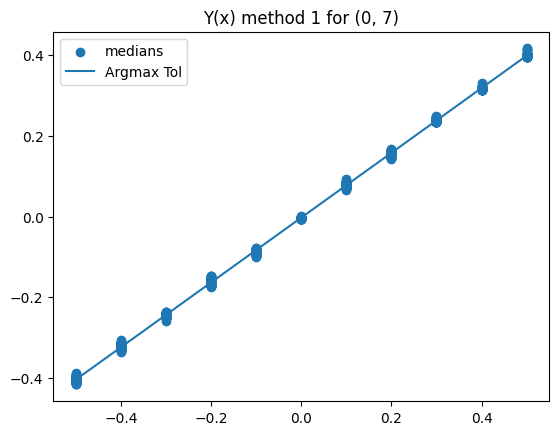

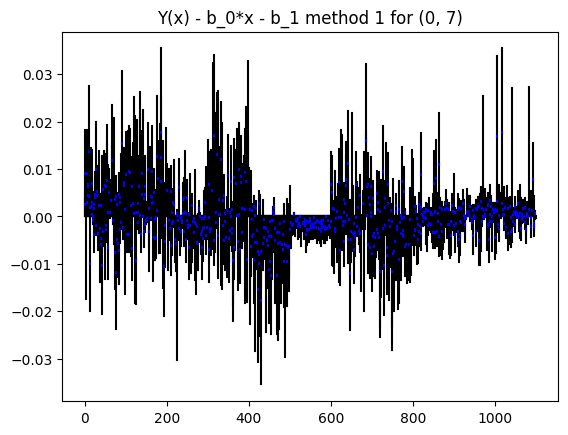

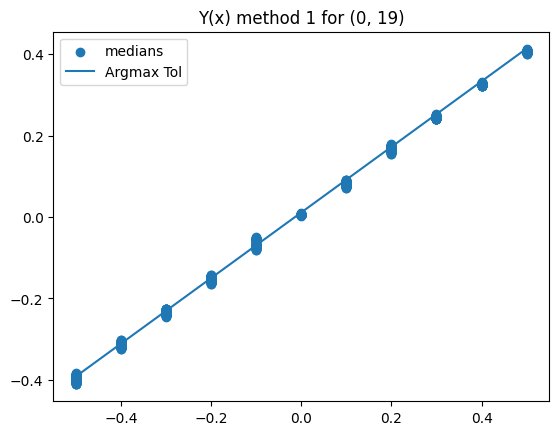

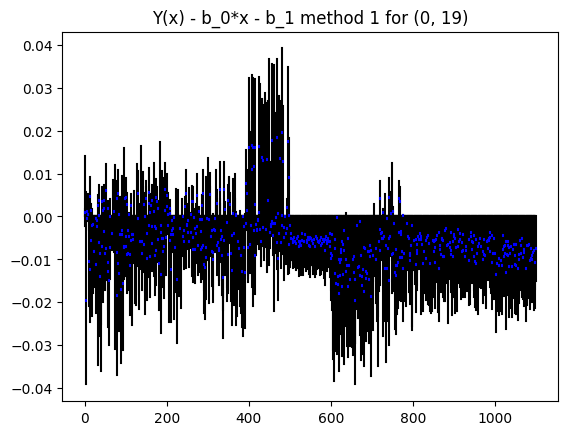

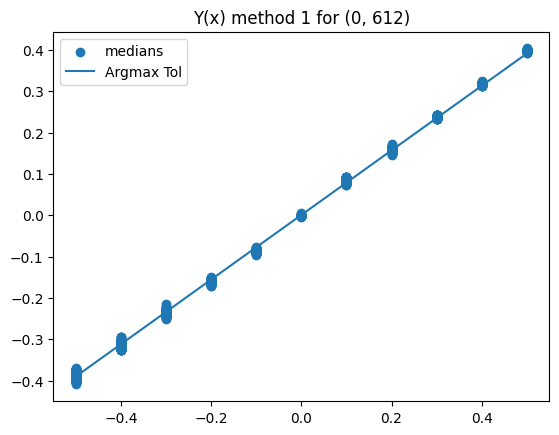

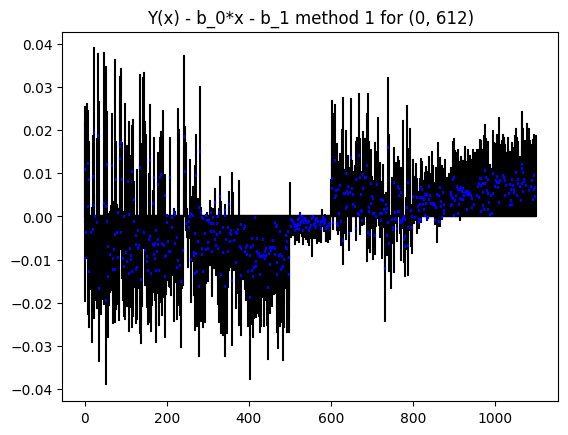

In [9]:
print("tol")
for f in f_values.values():
    b_vec, rads, neg = regression_type_tol(data[f])
    x, y = zip(*data[f])
    plt.figure()
    plt.title("Y(x) method 1 for " + str(f))
    plt.scatter(x, y, label="medians")
    plt.plot([-0.5, 0.5], [b_vec[1] + b_vec[0] * -0.5, b_vec[1] + b_vec[0] * 0.5], label="Argmax Tol")
    plt.legend()
    print(f, 1, b_vec[0], b_vec[1], neg)

    plt.figure()
    plt.title("Y(x) - b_0*x - b_1 method 1 for " + str(f))
    for i in range(len(y)):
        plt.plot([i, i], [y[i] - rads[i] - b_vec[1] - b_vec[0] * x[i],
                          y[i] + rads[i] - b_vec[1] - b_vec[0] * x[i]], color="k", zorder=1)
        plt.plot([i, i], [y[i] - 1 / 16384 - b_vec[1] - b_vec[0] * x[i],
                          y[i] + 1 / 16384 - b_vec[1] - b_vec[0] * x[i]], color="blue", zorder=2)

uni
(0, 7) 2 0.803271684062871071293169831867246284 -0.00384544955134316867157190706532837555 0
(0, 19) 2 0.80083550162182659537535300842137076 0.00564609656350308234590677180003738813 10
(0, 612) 2 0.795596044495126083427704970574232386 -0.00195324607940087937431699005084993972 18


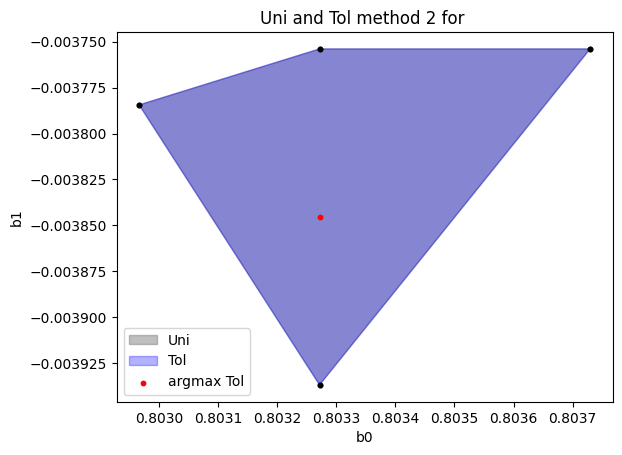

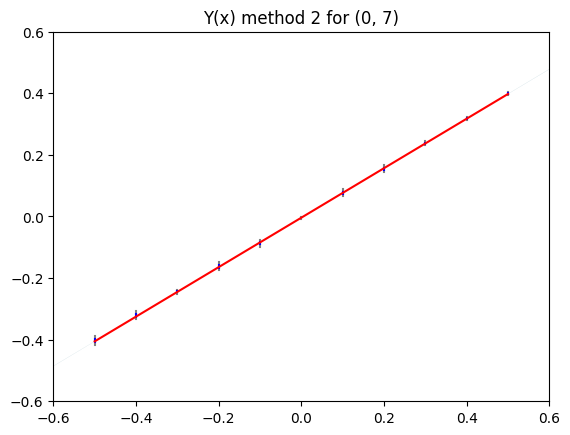

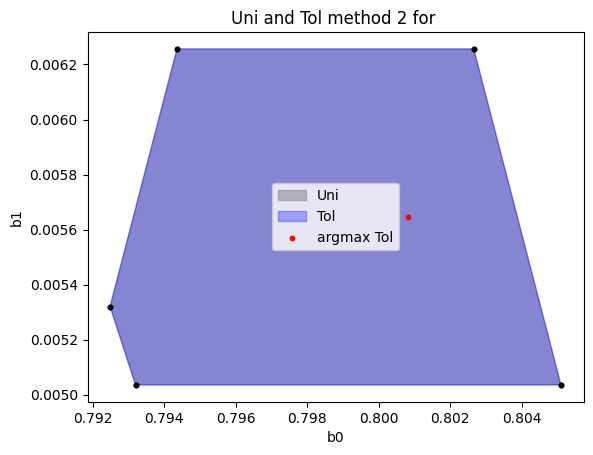

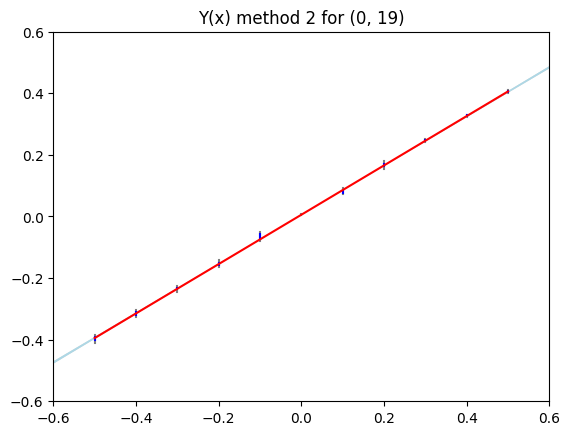

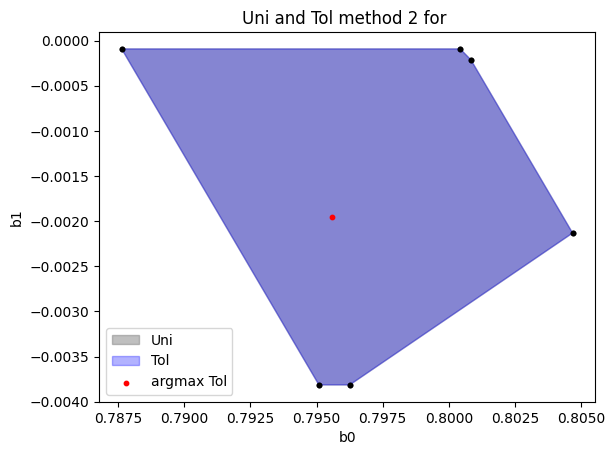

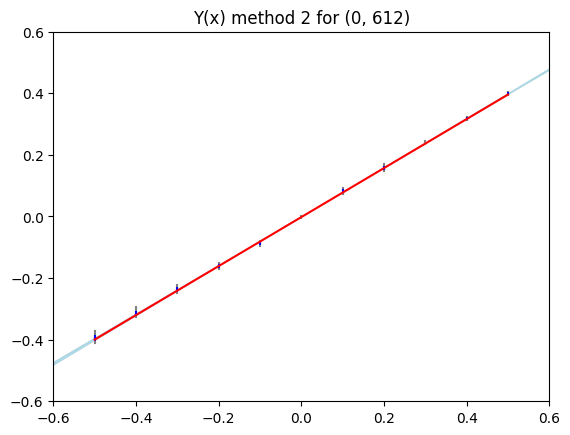

In [10]:
print("uni")
for f in f_values.values():
    # plt.figure()
    # plt.title("Uni and Tol method 2 for " + str(f))
    b_vec2, y_in, y_ex, neg, b_uni_vertices, b_tol_vertices = regression_type_uni(data[f])
    print(f, 2, b_vec2[0], b_vec2[1], len(neg))
    x2 = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
    plt.figure()
    plt.title("Y(x) method 2 for " + str(f))
    for i in range(len(x2)):
        plt.plot([x2[i], x2[i]], [y_ex[0][i], y_ex[1][i]], color="gray", zorder=1)
        plt.plot([x2[i], x2[i]], [y_in[0][i], y_in[1][i]], color="blue", zorder=2)

    plt.plot([-0.5, 0.5], [b_vec2[1] + b_vec2[0] * -0.5, b_vec2[1] + b_vec2[0] * 0.5], label="Argmax Tol", color="red",
             zorder=1000)

    x2 = [-3] + x2 + [3]

    for i in range(len(x2) - 1):
        x0 = x2[i]
        x1 = x2[i + 1]
        max_idx = 0
        min_idx = 0
        max_val = b_uni_vertices[0][1] + b_uni_vertices[0][0] * (x0 + x1) / 2
        min_val = b_uni_vertices[0][1] + b_uni_vertices[0][0] * (x0 + x1) / 2
        for j in range(len(b_uni_vertices)):
            val = b_uni_vertices[j][1] + b_uni_vertices[j][0] * (x0 + x1) / 2
            if max_val < val:
                max_idx = j
                max_val = val
            if min_val > val:
                min_idx = j
                min_val = val

        y0_low = b_uni_vertices[min_idx][1] + b_uni_vertices[min_idx][0] * x0
        y1_low = b_uni_vertices[min_idx][1] + b_uni_vertices[min_idx][0] * x1
        y0_hi = b_uni_vertices[max_idx][1] + b_uni_vertices[max_idx][0] * x0
        y1_hi = b_uni_vertices[max_idx][1] + b_uni_vertices[max_idx][0] * x1
        plt.fill([x0, x1, x1, x0], [y0_low, y1_low, y1_hi, y0_hi], facecolor="lightgray", linewidth=0)

        max_idx = 0
        min_idx = 0
        max_val = b_tol_vertices[0][1] + b_tol_vertices[0][0] * (x0 + x1) / 2
        min_val = b_tol_vertices[0][1] + b_tol_vertices[0][0] * (x0 + x1) / 2
        for j in range(len(b_tol_vertices)):
            val = b_tol_vertices[j][1] + b_tol_vertices[j][0] * (x0 + x1) / 2
            if max_val < val:
                max_idx = j
                max_val = val
            if min_val > val:
                min_idx = j
                min_val = val

        y0_low = b_tol_vertices[min_idx][1] + b_tol_vertices[min_idx][0] * x0
        y1_low = b_tol_vertices[min_idx][1] + b_tol_vertices[min_idx][0] * x1
        y0_hi = b_tol_vertices[max_idx][1] + b_tol_vertices[max_idx][0] * x0
        y1_hi = b_tol_vertices[max_idx][1] + b_tol_vertices[max_idx][0] * x1
        plt.fill([x0, x1, x1, x0], [y0_low, y1_low, y1_hi, y0_hi], facecolor="lightblue", linewidth=0)

    plt.xlim((-0.6, 0.6))
    plt.ylim((-0.6, 0.6))

In [32]:
values_x = [-2, 0, 2]
measurements_each_x_value = 100
shape_1 = 1
shape_2 = 1
eps = 1 / 10

left_x = -3
right_x = 3
bottom_y = -3
top_y = 3

def generate_data(step = 0.125, shift = 0):
    generated_data = [[]]

    data = [(values_x[0], values_x[0] - 2 * step) for i in range(measurements_each_x_value // 4)]
    data.extend([(values_x[0], values_x[0] - step) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[0], values_x[0] + step) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[0], values_x[0] + 2 * step) for i in range(measurements_each_x_value // 4)])

    data.extend([(values_x[1], values_x[1] - 2 * step + shift) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[1], values_x[1] - step + shift) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[1], values_x[1] + step + shift) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[1], values_x[1] + 2 * step + shift) for i in range(measurements_each_x_value // 4)])

    data.extend([(values_x[2], values_x[2] - 2 * step) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[2], values_x[2] - step) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[2], values_x[2] + step) for i in range(measurements_each_x_value // 4)])
    data.extend([(values_x[2], values_x[2] + 2 * step) for i in range(measurements_each_x_value // 4)])

    generated_data[0].append(data)

    return generated_data

data = generate_data()

In [33]:
# using Tol
def regression_type_1(points):
    x, y = zip(*points)

    weights = [eps] * len(y)
    X_mat = Interval([[[x_el, x_el], [1, 1]] for x_el in x])
    Y_vec = Interval([[y_el, weights[i]] for i, y_el in enumerate(y)], midRadQ=True)

    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat, Y_vec)
    updated = 0
    if tol_val < 0:
        for i in range(len(Y_vec)):
            X_mat_small = Interval([
                [[x[i], x[i]], [1, 1]]
            ])
            Y_vec_small = Interval([[y[i], weights[i]]], midRadQ=True)
            value = Tol.value(X_mat_small, Y_vec_small, b_vec)
            if value < 0:
                weights[i] = abs(y[i] - (x[i] * b_vec[0] + b_vec[1])) + 1e-8
                updated += 1

    Y_vec = Interval([[y_el, weights[i]] for i, y_el in enumerate(y)], midRadQ=True)

    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat, Y_vec)

    return b_vec, weights, updated

In [34]:
coord_1, coord_2 = 0, 0
data = data[coord_1][coord_2]

(0, 0) 1 0.9999999999999994 4.807406715958909e-17 300


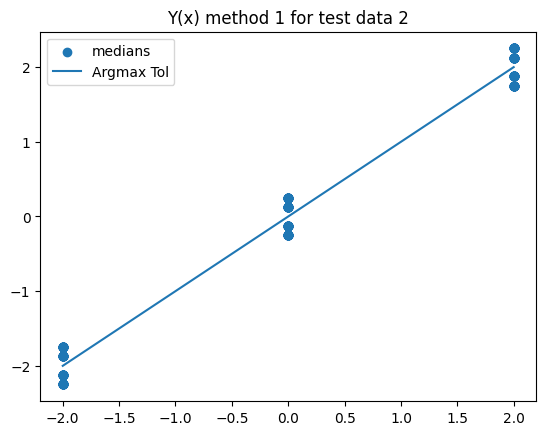

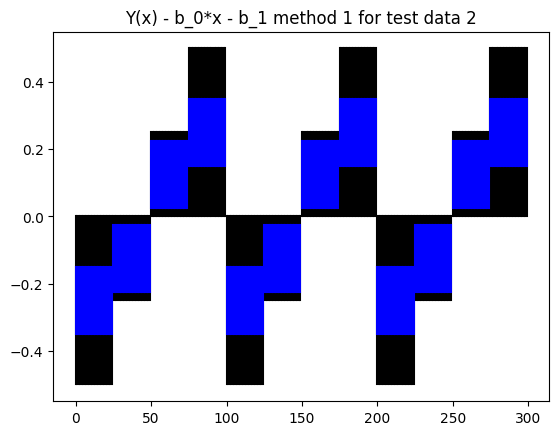

In [ ]:
# method 1
b_vec, rads, to_remove = regression_type_1(data)
x, y = zip(*data)
plt.figure()
plt.title("Y(x) method 1 for test data")#+ str((coord_1, coord_2)))
plt.scatter(x, y, label="medians")
plt.plot([min(values_x), max(values_x)], [b_vec[1] + b_vec[0] * min(values_x), b_vec[1] + b_vec[0] * max(values_x)], label="Argmax Tol")
plt.legend()
print((coord_1, coord_2), 1, b_vec[0], b_vec[1], to_remove)
plt.savefig(f"test_2_method_1.png")

plt.figure()
plt.title("Y(x) - b_0*x - b_1 method 1 for test data")#+ str((coord_1, coord_2)))
for i in range(len(y)):
    plt.plot([i, i], [y[i] - rads[i] - b_vec[1] - b_vec[0] * x[i],
                        y[i] + rads[i] - b_vec[1] - b_vec[0] * x[i]], color="k", zorder=1)
    plt.plot([i, i], [y[i] - eps - b_vec[1] - b_vec[0] * x[i],
                        y[i] + eps - b_vec[1] - b_vec[0] * x[i]], color="blue", zorder=2)
plt.savefig(f"test_2_method_1_difference.png")

In [36]:
def regression_type_2(points):
    x, y = zip(*points)

    y_ex_up = [-float('inf')] * len(values_x)
    y_ex_down = [float('inf')] * len(values_x)
    y_in_up = [-float('inf')] * len(values_x)
    y_in_down = [float('inf')] * len(values_x)

    q_1 = measurements_each_x_value // 4
    q_3 = measurements_each_x_value * 3 // 4 - 1

    for i in range(len(values_x)):
        y_list = list(y[i * measurements_each_x_value : (i + 1) * measurements_each_x_value])
        y_list.sort()
        y_in_down[i] = y_list[q_1] - eps
        y_in_up[i] = y_list[q_3] + eps
        y_ex_up[i] = min(y_list[q_3] + 1.5 * (y_list[q_3] - y_list[q_1]), y_list[-1])
        y_ex_down[i] = max(y_list[q_1] - 1.5 * (y_list[q_3] - y_list[q_1]), y_list[0])

    X_mat = []
    Y_vec = []
    for i in range(len(values_x)):
        x_el = values_x[i]
        # y_ex_up >= X_mat * b >= y_ex_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_ex_down[i], y_ex_up[i]])
        # y_in_up >= X_mat * b >= y_ex_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_ex_down[i], y_in_up[i]])
        # y_ex_up >= X_mat * b >= y_in_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_in_down[i], y_ex_up[i]])
        # y_in_up >= X_mat * b >= y_in_down
        X_mat.append([[x_el, x_el], [1, 1]])
        Y_vec.append([y_in_down[i], y_in_up[i]])

    X_mat_interval = Interval(X_mat)
    Y_vec_interval = Interval(Y_vec)
    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat_interval, Y_vec_interval)
    to_remove = []
    if tol_val < 0:
        for i in range(len(Y_vec)):
            X_mat_small = Interval([X_mat[i]])
            Y_vec_small = Interval([Y_vec[i]])
            value = Tol.value(X_mat_small, Y_vec_small, b_vec)
            if value < 0:
                to_remove.append(i)

        for i in sorted(to_remove, reverse=True):
            del X_mat[i]
            del Y_vec[i]

    X_mat_interval = Interval(X_mat)
    Y_vec_interval = Interval(Y_vec)
    b_vec, tol_val, num_iter, calcfg_num, exit_code = Tol.maximize(X_mat_interval, Y_vec_interval)

    vertices1 = IntLinIncR2(X_mat_interval, Y_vec_interval)
    vertices2 = IntLinIncR2(X_mat_interval, Y_vec_interval, consistency='tol')

    plt.xlabel("b0")
    plt.ylabel("b1")
    b_uni_vertices = []
    for v in vertices1:
        if len(v) > 0:
            x, y = v[:, 0], v[:, 1]
            b_uni_vertices += [(x[i], y[i]) for i in range(len(x))]
            plt.fill(x, y, linestyle='-', linewidth=1, color='gray', alpha=0.5, label="Uni")
            plt.scatter(x, y, s=0, color='black', alpha=1)


    b_tol_vertices = []
    for v in vertices2:
        if len(v) > 0:
            x, y = v[:, 0], v[:, 1]
            b_tol_vertices += [(x[i], y[i]) for i in range(len(x))]
            plt.fill(x, y, linestyle='-', linewidth=1, color='blue', alpha=0.3, label="Tol")
            plt.scatter(x, y, s=10, color='black', alpha=1)

    plt.scatter([b_vec[0]], [b_vec[1]], s=10, color='red', alpha=1, label="argmax Tol")
    plt.legend()
    return b_vec, (y_in_down, y_in_up), (y_ex_down, y_ex_up), to_remove, b_uni_vertices, b_tol_vertices

(0, 0) 2 0.9999999999999998 6.159489854822354e-17 0


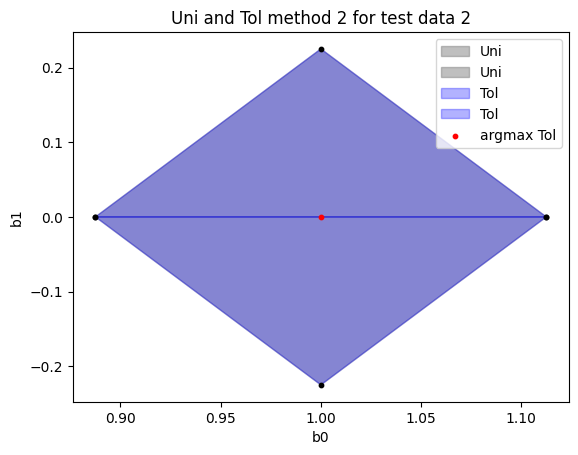

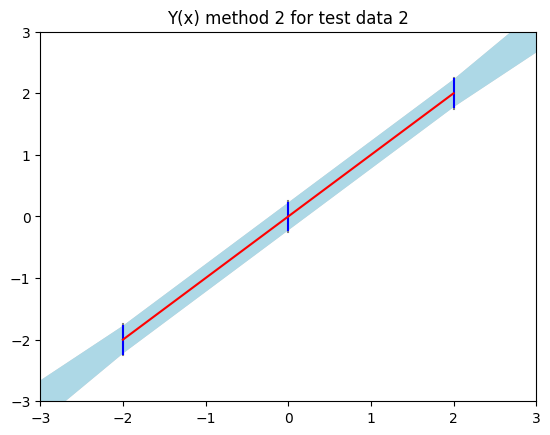

In [37]:
plt.figure()
plt.title("Uni and Tol method 2 for test data")#+ str((coord_1, coord_2)))
b_vec2, y_in, y_ex, to_remove, b_uni_vertices, b_tol_vertices = regression_type_2(data)
print((coord_1, coord_2), 2, b_vec2[0], b_vec2[1], len(to_remove))
plt.savefig(f"test_2_method_2.png")
plt.figure()
plt.title("Y(x) method 2 for test data")#+ str((coord_1, coord_2)))
for i in range(len(values_x)):
    plt.plot([values_x[i], values_x[i]], [y_ex[0][i], y_ex[1][i]], color="gray", zorder=1)
    plt.plot([values_x[i], values_x[i]], [y_in[0][i], y_in[1][i]], color="blue", zorder=2)

plt.plot([min(values_x), max(values_x)], [b_vec2[1] + b_vec2[0] * min(values_x), b_vec2[1] + b_vec2[0] * max(values_x)], label="Argmax Tol", color="red",
            zorder=1000)

x2 = [left_x] + values_x + [right_x]

for i in range(len(x2) - 1):
    x0 = x2[i]
    x1 = x2[i + 1]
    max_idx = 0
    min_idx = 0
    max_val = b_uni_vertices[0][1] + b_uni_vertices[0][0] * (x0 + x1) / 2
    min_val = b_uni_vertices[0][1] + b_uni_vertices[0][0] * (x0 + x1) / 2
    for j in range(len(b_uni_vertices)):
        val = b_uni_vertices[j][1] + b_uni_vertices[j][0] * (x0 + x1) / 2
        if max_val < val:
            max_idx = j
            max_val = val
        if min_val > val:
            min_idx = j
            min_val = val

    y0_low = b_uni_vertices[min_idx][1] + b_uni_vertices[min_idx][0] * x0
    y1_low = b_uni_vertices[min_idx][1] + b_uni_vertices[min_idx][0] * x1
    y0_hi = b_uni_vertices[max_idx][1] + b_uni_vertices[max_idx][0] * x0
    y1_hi = b_uni_vertices[max_idx][1] + b_uni_vertices[max_idx][0] * x1
    plt.fill([x0, x1, x1, x0], [y0_low, y1_low, y1_hi, y0_hi], facecolor="lightgray", linewidth=0)

    max_idx = 0
    min_idx = 0
    max_val = b_tol_vertices[0][1] + b_tol_vertices[0][0] * (x0 + x1) / 2
    min_val = b_tol_vertices[0][1] + b_tol_vertices[0][0] * (x0 + x1) / 2
    for j in range(len(b_tol_vertices)):
        val = b_tol_vertices[j][1] + b_tol_vertices[j][0] * (x0 + x1) / 2
        if max_val < val:
            max_idx = j
            max_val = val
        if min_val > val:
            min_idx = j
            min_val = val

    y0_low = b_tol_vertices[min_idx][1] + b_tol_vertices[min_idx][0] * x0
    y1_low = b_tol_vertices[min_idx][1] + b_tol_vertices[min_idx][0] * x1
    y0_hi = b_tol_vertices[max_idx][1] + b_tol_vertices[max_idx][0] * x0
    y1_hi = b_tol_vertices[max_idx][1] + b_tol_vertices[max_idx][0] * x1
    plt.fill([x0, x1, x1, x0], [y0_low, y1_low, y1_hi, y0_hi], facecolor="lightblue", linewidth=0)

plt.xlim((left_x, right_x))
plt.ylim((bottom_y, top_y))
plt.savefig(f"test_2_method_2_corridor_joint_dependence.png")